In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

data_path = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
             "heart-disease/processed.cleveland.data")
df = pd.read_csv(data_path)

# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 4
df = df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

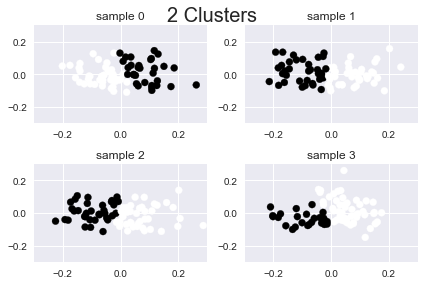

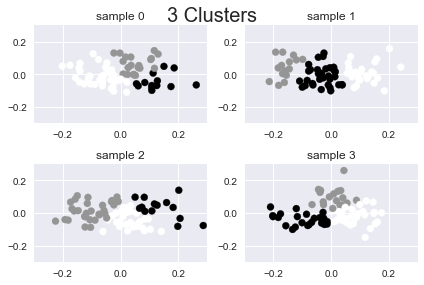

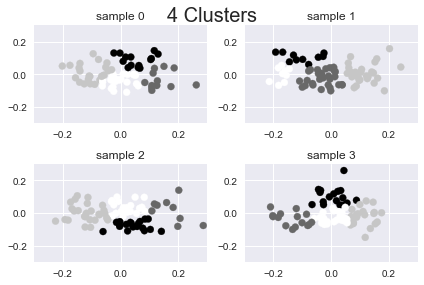

In [15]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [16]:
full_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_norm)

pd.crosstab(y, full_pred) 

col_0,0,1
row_0,,
0,84,54
1,65,97


In [17]:
# Note: the itertools module is tons of fun and very useful.
import itertools

# Create a list of pairs, where each pair is the ground truth group
# and the assigned cluster.
c = list(itertools.product(y, full_pred))

# Count how often each type of pair (a, b, c, or d) appears.
RIcounts = [[x, c.count(x)] for x in set(c)]
print(RIcounts)

# Create the same counts but without the label, for easier math below.
RIcounts_nolabel = [c.count(x) for x in set(c)]

# Calculate the Rand Index.
RIscore = (RIcounts_nolabel[3] + RIcounts_nolabel[2]) / np.sum(RIcounts_nolabel)
print(RIscore)

[[(0, 1), 20838], [(1, 0), 24138], [(0, 0), 20562], [(1, 1), 24462]]
0.500266666667


In [18]:
from sklearn import metrics
    
metrics.adjusted_rand_score(y, full_pred)

0.039519228275737305

In [19]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.367728432826
0.384500252054
0.377282692015
0.375225768056
